In [2]:
!pip install numpy pandas matplotlib torch keras torchmetrics lightning torchinfo torchvision
!apt-get install tree


E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


We are working with the Sign Language MNIST dataset.
First we need to load the dataset for training and testing from the CSV files.

In [3]:
import pandas as pd

training_df = pd.read_csv("../dataset/sign_mnist_train.csv") 
testing_df = pd.read_csv("../dataset/sign_mnist_test.csv")

Extract Labels and Features

In [4]:
y_train = training_df['label']
training_df.drop(['label'], axis=1, inplace=True)

y_test = testing_df['label']
testing_df.drop(['label'], axis=1, inplace=True)

Define Constrants and reshape the data

In [5]:
# Model parameters
size = 28
channels = 1
batch = 128
epochs = 10

X_train = training_df.values.reshape(training_df.shape[0], size, size, channels)
X_test = testing_df.values.reshape(testing_df.shape[0], size, size, channels)

Data Augmentation and Generators

In [6]:
import torch
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train.reshape(-1, 1, size, size)).float()
y_train_tensor = torch.tensor(y_train.values).long()

X_test_tensor = torch.tensor(X_test.reshape(-1, 1, size, size)).float()
y_test_tensor = torch.tensor(y_test.values).long()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

training_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=True, num_workers=11)
val_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False, num_workers=11)

Base Model

In [7]:
from typing import Tuple
from lightning.pytorch import LightningModule
from torch import nn
import torch
from torch import Tensor
import torchmetrics

class BaseModel(LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.accuracy = torchmetrics.classification.Accuracy(
            task="multiclass",
            num_classes=num_classes)
        self.model = self.build_model()

    def build_model(self):
      def build_model(self):
        self.layer1 = nn.Sequential(nn.Flatten(), nn.Linear(size*size, self.num_classes))
        return self.layer1

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def forward(self, x):
        return self.model(x)

    def loss(self, logits, target):
        return nn.functional.cross_entropy(logits, target)

    def shared_step(self, mode:str, batch:Tuple[Tensor, Tensor], batch_index:int):
        x, target = batch
        output = self.forward(x)
        loss = self.loss(output, target)
        self.accuracy(output, target)
        self.log(f"{mode}_step_acc", self.accuracy, prog_bar=True)
        self.log(f"{mode}_step_loss", loss, prog_bar=False)
        return loss

    def training_step(self, batch, batch_index):
        return self.shared_step('train', batch, batch_index)

    def validation_step(self, batch, batch_index):
        return self.shared_step('val', batch, batch_index)

    def test_step(self, batch, batch_index):
        return self.shared_step('test', batch, batch_index)

Helper Functions from Assignment 2

In [8]:
import torchinfo
def describe(model, **kwargs):
    return torchinfo.summary(model,
                             input_size=(batch, 1, size, size),
                             col_names=['input_size', 'output_size', 'kernel_size', 'num_params'],
                             row_settings=['ascii_only'])

In [9]:
import shutil
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch import Trainer, seed_everything

def train(model):
    name = model.__class__.__name__
    shutil.rmtree(f'./lightning_logs/{name}', ignore_errors=True)
    seed_everything(0, workers=True)
    logger = CSVLogger('./lightning_logs', name=name)
    trainer = Trainer(max_epochs=epochs, logger=logger, deterministic=True)
    trainer.fit(model,
                train_dataloaders=training_dataloader,
                val_dataloaders=val_dataloader)

In [10]:
def show_metrics(name):
    df = pd.read_csv(f'./lightning_logs/{name}/version_0/metrics.csv')
    df.set_index('step', inplace=True)
    ax = df[['train_step_acc']].dropna().plot()
    df[['val_step_acc']].dropna().plot(ax=ax)
    return df[['val_step_acc']].dropna().round(2)

Convolution Net Model

In [11]:
class ConvNet(BaseModel):
    def __init__(self, num_classes, num_kernels, kernel_size, pool_size):
        self.num_kernels = num_kernels
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        super().__init__(num_classes)

    def build_model(self):
        return nn.Sequential(
            nn.Conv2d(1, out_channels = self.num_kernels, kernel_size = self.kernel_size, padding = 1),
            nn.MaxPool2d(kernel_size = self.pool_size),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(784, self.num_classes)
        )

In [12]:
conv_model = ConvNet(26, 4, 3, 2)
describe(conv_model)

Layer (type)                             Input Shape               Output Shape              Kernel Shape              Param #
ConvNet                                  [128, 1, 28, 28]          [128, 26]                 3                         --
+ Sequential                             [128, 1, 28, 28]          [128, 26]                 --                        --
|    + Conv2d                            [128, 1, 28, 28]          [128, 4, 28, 28]          [3, 3]                    40
|    + MaxPool2d                         [128, 4, 28, 28]          [128, 4, 14, 14]          2                         --
|    + ReLU                              [128, 4, 14, 14]          [128, 4, 14, 14]          --                        --
|    + Flatten                           [128, 4, 14, 14]          [128, 784]                --                        --
|    + Linear                            [128, 784]                [128, 26]                 --                        20,410
Total params: 2

In [13]:
train(conv_model)

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs/ConvNet
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0     
1 | model    | Sequential         | 20.4 K
------------------------------------------------
20.4 K    Trainable params
0         Non-trainable params
20.4 K    Total params
0.082     Total estimated model params size (MB)


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 215/215 [00:02<00:00, 102.66it/s, v_num=0, train_step_acc=1.000]
Validation: |                                                                                                                                         | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  74%|████████████████████████████████████████████████████████████████████████████████▎                            | 42/57 [00:00<00:00, 107.82it/s]


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████| 215/215 [00:02<00:00, 93.64it/s, v_num=0, train_step_acc=1.000, val_step_acc=0.722]
Validation: |                                                                                                                                         | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  47%|███████████████████████████████████████████████████▋                                                         | 27/57 [00:00<00:00, 133.05it/s]


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████| 215/215 [00:02<00:00, 93.71it/s, v_num=0, train_step_acc=1.000, val_step_acc=0.947]
Validation: |                                                                                                                                         | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  21%|██████████████████████▉                                                                                      | 12/57 [00:00<00:00, 126.93it/s]


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████| 215/215 [00:02<00:00, 93.32it/s, v_num=0, train_step_acc=1.000, val_step_acc=0.949]


Validation: |                                                                                                                                         | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  75%|██████████████████████████████████████████████████████████████████████████████████▏                          | 43/57 [00:00<00:00, 152.98it/s]


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████| 215/215 [00:02<00:00, 96.06it/s, v_num=0, train_step_acc=1.000, val_step_acc=0.950]
Validation: |                                                                                                                                         | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  49%|█████████████████████████████████████████████████████▌                                                       | 28/57 [00:00<00:00, 146.74it/s]


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████| 215/215 [00:02<00:00, 96.28it/s, v_num=0, train_step_acc=1.000, val_step_acc=0.953]
Validation: |                                                                                                                                         | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  23%|████████████████████████▊                                                                                    | 13/57 [00:00<00:00, 132.65it/s]


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████| 215/215 [00:02<00:00, 92.86it/s, v_num=0, train_step_acc=1.000, val_step_acc=0.954]
Validation: |                                                                                                                                         | 0/? [00:00<?, ?it/s]


Validation DataLoader 0:  77%|████████████████████████████████████████████████████████████████████████████████████▏                        | 44/57 [00:00<00:00, 143.99it/s]


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████| 215/215 [00:02<00:00, 94.64it/s, v_num=0, train_step_acc=1.000, val_step_acc=0.953]
Validation: |                                                                                                                                         | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  51%|███████████████████████████████████████████████████████▍                                                     | 29/57 [00:00<00:00, 131.31it/s]


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████| 215/215 [00:02<00:00, 96.29it/s, v_num=0, train_step_acc=1.000, val_step_acc=0.953]
Validation: |                                                                                                                                         | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██████████████████████████▊                                                                                  | 14/57 [00:00<00:00, 128.37it/s]


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████| 215/215 [00:02<00:00, 93.68it/s, v_num=0, train_step_acc=1.000, val_step_acc=0.955]
Validation: |                                                                                                                                         | 0/? [00:00<?, ?it/s]
Validation:   0%|                                                                                                                                    | 0/57 [00:00<?, ?it/s]


Validation DataLoader 0:  79%|██████████████████████████████████████████████████████████████████████████████████████                       | 45/57 [00:00<00:00, 143.67it/s]


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████| 215/215 [00:03<00:00, 71.03it/s, v_num=0, train_step_acc=1.000, val_step_acc=0.955]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████| 215/215 [00:03<00:00, 70.82it/s, v_num=0, train_step_acc=1.000, val_step_acc=0.955]


In [14]:
! tree -n ./lightning_logs/ConvNet/

/bin/bash: tree: command not found


,val_step_acc
step,
214,0.72
429,0.95
644,0.95
859,0.95
1074,0.95
1289,0.95
1504,0.95
1719,0.95
1934,0.95


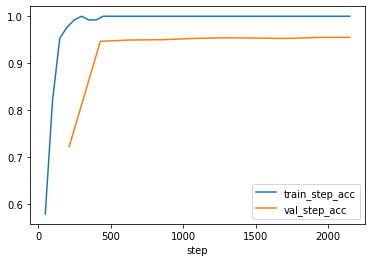

In [15]:
show_metrics('ConvNet')